In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import networkx as nx
import numpy as np
import pandas as pd

# Create and Explore Graph

In [ ]:
df = pd.read_csv(
    "../datasets/soc-sign-bitcoinotc.csv", 
    names = ["source", "target", "rating", "timestamp"], 
    usecols=["source", "target", "rating"]
    )

df_clean = df[df['rating'] > 0]

print("Number of edges before cleaning:", len(df))
print("After:", len(df_clean))

bitcoin_otc_trust_graph = nx.from_pandas_edgelist(
    df_clean,
    source="source",
    target="target",
    create_using=nx.DiGraph,
    edge_attr="rating",
)


Number of edges before cleaning: 35592
After: 32029


Number of nodes:  5573
Outdegree:


count    5573.000000
mean        5.747174
std        19.023075
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       753.000000
Name: outdegree, dtype: float64

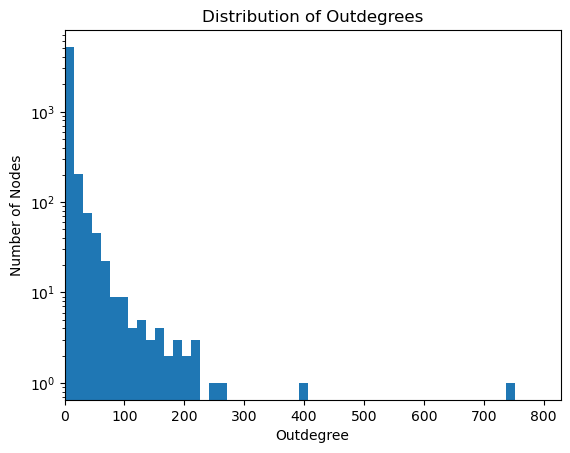

In [73]:
print("Number of nodes: ", len(bitcoin_otc_trust_graph))

outdegrees = pd.DataFrame(bitcoin_otc_trust_graph.out_degree(), columns=["node", "outdegree"])
print("Outdegree:")
display(outdegrees['outdegree'].describe())

plt.figure()
plt.hist(outdegrees['outdegree'], bins=50)
plt.xlabel('Outdegree')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Outdegrees')
plt.yscale('log')
plt.xlim(0, outdegrees['outdegree'].max() * 1.1) 
plt.show()

In [58]:
bitcoin_otc_trust_graph_prepared = None
bitcoin_otc_trust_graph_prepared = graph_tools.prepare_graph(bitcoin_otc_trust_graph.nodes(), bitcoin_otc_trust_graph.edges(), sink_frac=0.0)
bitcoin_otc_trust_graph_prepared = graph_tools.nx_graph_nodes_to_str(bitcoin_otc_trust_graph_prepared)
nodes = bitcoin_otc_trust_graph_prepared.nodes()
delegations_orig = graph_tools.nx_graph_to_dict(bitcoin_otc_trust_graph_prepared)
delegations = graph_tools.invert_graph(delegations_orig)

In [69]:
# Number of sinks vs total number of nodes
sinks = [node for node in nodes if len(delegations_orig[node]) == 0]
print("Number of sinks:", len(sinks))
print("Total number of nodes:", len(nodes))
print("Fraction of sinks:", len(sinks) / len(nodes))

Number of sinks: 806
Total number of nodes: 5530
Fraction of sinks: 0.145750452079566


2025-06-24 15:24:09,912 - INFO - Initially 5573 nodes, after collapsing terminal SCCs 5530 nodes remain. In total 18 terminal SCCs were collapsed.

In [70]:
removed_nodes = 5573 - 5530
amount_of_clos_deg_cycles = 18
print("Amount of removed edges", removed_nodes)
print("Fraction of removed nodes:", removed_nodes / len(nodes))
print("Average number of nodes per closed delegation cycle:", removed_nodes / amount_of_clos_deg_cycles)

Amount of removed edges 43
Fraction of removed nodes: 0.007775768535262206
Average number of nodes per closed delegation cycle: 2.388888888888889


# Explore powers

In [59]:
powers, sinks = le.resolve_delegations(delegations, nodes)

In [60]:
powers_df = pd.DataFrame.from_dict(powers, orient="index", columns=["power"])
powers_df.describe()

,power
count,5530.000000
mean,1.000000
std,8.293814
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,410.792163


In [71]:
lost_power = powers_df.loc["lost"] + removed_nodes
print("Total lost power:", lost_power)
print("Fraction of lost power:", lost_power / len(nodes))

Total lost power: power    111.212747
Name: lost, dtype: float64
Fraction of lost power: power    0.020111
Name: lost, dtype: float64


In [61]:
display(powers_df.sort_values(by="power", ascending=False))


,power
25,410.792163
2198,390.658912
5775,92.077641
2455,75.264206
lost,68.212747
...,...
2185,0.000000
2184,0.000000
2176,0.000000
2182,0.000000


In [62]:
print("Number of sinks:", len(sinks))
print("Total number of nodes:", len(nodes))
print("Fraction of sinks:", len(sinks) / len(nodes))

Number of sinks: 806
Total number of nodes: 5530
Fraction of sinks: 0.145750452079566


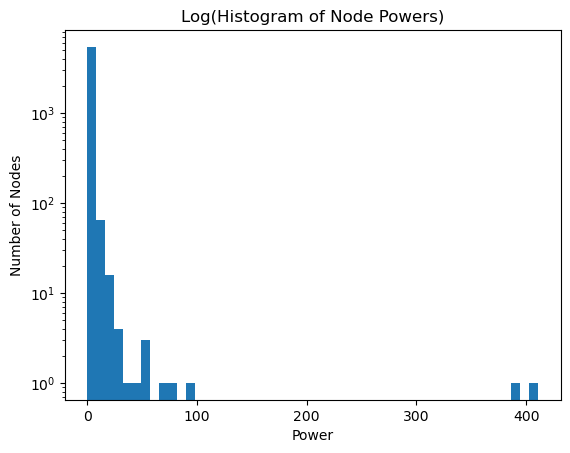

In [ ]:
plt.hist(powers_df['power'], bins=50)
plt.xlabel('Power')
plt.ylabel('Number of Nodes')
plt.title('Histogram of Node Powers')
plt.yscale('log')
plt.show()

# Benchmarking

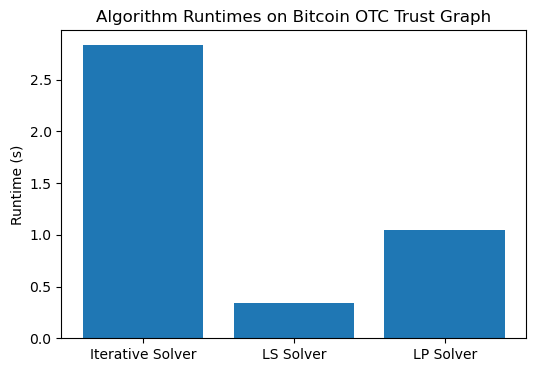

In [ ]:
logger, handler = logger_creator.create_logger("benchmarking")

# Verify the solutions are equal
powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
powers_iter = iterative.iterate_delegations(delegations, nodes)

if powers_le != powers_lp:
    logger.error("Powers do not match")
    logger.error(f"LE: {powers_le}")
    logger.error(f"LP: {powers_lp}")
    print("Mismatching powers in LE and LP. Check the log file for details.")
    
for node in sinks_le:
    if (powers_lp[node] - powers_iter[node] < 0.01):
        continue
    else: 
        logger.error("Powers do not match")
        logger.error(f"LP: {powers_lp}")
        logger.error(f"Iterative: {powers_iter}")
        print("Mismatching powers in LP and Iterative. Check the log file for details.")
        break

n = 2

# LE
le_model = le.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    le.solve(*le_model)
end_time = time.time()
        
time_le = (end_time - start_time) / n

# LP
lp_model = lp.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    lp.solve(*lp_model)
end_time = time.time()

time_lp = (end_time - start_time) / n

# Iterative
start_time = time.time()
for _ in range(n):
    p = iterative.iterate_delegations(delegations, nodes)
end_time = time.time()

time_iterative = (end_time - start_time) / n


logger.removeHandler(handler)
handler.close()

plt.figure(figsize=(6,4))
plt.bar(["Iterative Solver", "LS Solver", "LP Solver"], [time_iterative, time_le, time_lp])
plt.ylabel("Runtime (s)")
plt.title("Algorithm Runtimes on Bitcoin OTC Trust Graph")
plt.show()

In [55]:
powers_iter[3]

57.02658470043822

In [57]:
powers_lp['3']

0.0